## **Project Title: Portfolio Diversification and Risk Reduction**

**Introduction:**  
This project explores how portfolio diversification impacts risk reduction by analyzing stock prices  
from NIFTY 50, India’s top 50 companies listed in the National Stock Exchange. Diversification,  
spreading investments across various companies, can theoretically minimize unsystematic risk.  
By constructing and analyzing portfolios with varying levels of diversification, this study aims  
to evaluate whether a diversified portfolio delivers better risk-adjusted returns compared  
to concentrated ones. Using metrics like the Sharpe ratio, portfolio return, and volatility, we  
examine whether holding a diverse set of stocks leads to superior performance and lower risk   
relative to more concentrated portfolios.

*"A diversified portfolios will have a higher Sharpe ratio and a lower standard deviation of returns compared to a concentrated portfolio, indicating better risk-adjusted performance."*


### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy import stats

# Set plot style
sns.set(style='whitegrid')

# Display plots inline
%matplotlib inline

### Loading datasets

In [2]:
nifty50_companies = pd.read_csv('data/NIFTY50_Stocks/NIFTY50_COMPANIESLIST.CSV')
print(nifty50_companies.head(10))

                         Industry      Symbol Series     ISIN Code
0                 Metals & Mining    ADANIENT     EQ  INE423A01024
1                        Services  ADANIPORTS     EQ  INE742F01042
2                      Healthcare  APOLLOHOSP     EQ  INE437A01024
3               Consumer Durables  ASIANPAINT     EQ  INE021A01026
4              Financial Services    AXISBANK     EQ  INE238A01034
5  Automobile and Auto Components  BAJAJ-AUTO     EQ  INE917I01010
6              Financial Services  BAJFINANCE     EQ  INE296A01024
7              Financial Services  BAJAJFINSV     EQ  INE918I01026
8      Oil Gas & Consumable Fuels        BPCL     EQ  INE029A01011
9               Telecommunication  BHARTIARTL     EQ  INE397D01024


In [3]:
import os
stock_data = {}

for symbol in nifty50_companies['Symbol']:
    file_path = os.path.join('data/NIFTY50_Stocks/NIFTY50/', f'{symbol}.NS.csv')
    stock_data[symbol] = pd.read_csv(file_path)

print(stock_data['BPCL'].tail(5))

            Date        Open        High         Low       Close   Adj Close  \
6590  2023-03-17  351.000000  354.950012  345.450012  351.399994  351.399994   
6591  2023-03-20  354.850006  361.000000  350.500000  359.649994  359.649994   
6592  2023-03-21  360.200012  361.600006  355.750000  358.549988  358.549988   
6593  2023-03-22  358.299988  359.000000  350.750000  351.799988  351.799988   
6594  2023-03-23  350.000000  351.649994  347.500000  348.350006  348.350006   

          Volume  
6590  11694506.0  
6591   9246173.0  
6592   5125281.0  
6593   5967027.0  
6594   2573088.0  


### Data cleaning

In [4]:

# Data Cleaning

# checking for missing values
for symbol, df in stock_data.items():
    if df.isnull().values.any():
        print(f'{symbol} has missing values')
        if symbol=="ICICIBANK":
            print(df[df.isnull().any(axis=1)])  # print rows with missing values
    stock_data[symbol]['Date'] = pd.to_datetime(df['Date']) # ensuring the date column is in datetime format
    
    
# fill missing values using linear interpolation
for symbol, df in stock_data.items():
    stock_data[symbol].interpolate(method='linear', inplace=True)

# forward fill for the last row's missing values
for symbol, df in stock_data.items():
    stock_data[symbol].ffill(inplace=True)

# backward fill for the first row's missing values
for symbol, df in stock_data.items():
    stock_data[symbol].bfill(inplace=True)

# re-check for missing values
for symbol, df in stock_data.items():
    if df.isnull().values.any():
        break
else:
    print('\nNo missing values in the stock data')
        



ADANIENT has missing values
ADANIPORTS has missing values
APOLLOHOSP has missing values
ASIANPAINT has missing values
AXISBANK has missing values
BAJAJ-AUTO has missing values
BAJFINANCE has missing values
BAJAJFINSV has missing values
BPCL has missing values
BHARTIARTL has missing values
BRITANNIA has missing values
CIPLA has missing values
COALINDIA has missing values
DIVISLAB has missing values
DRREDDY has missing values
EICHERMOT has missing values
GRASIM has missing values
HCLTECH has missing values
HDFCBANK has missing values
HEROMOTOCO has missing values
HINDALCO has missing values
HINDUNILVR has missing values
HDFC has missing values
ICICIBANK has missing values
            Date  Open  High  Low  Close  Adj Close  Volume
73    2003-04-14   NaN   NaN  NaN    NaN        NaN     NaN
343   2004-04-26   NaN   NaN  NaN    NaN        NaN     NaN
465   2004-10-13   NaN   NaN  NaN    NaN        NaN     NaN
1781  2010-02-06   NaN   NaN  NaN    NaN        NaN     NaN
2259  2012-01-07   Na

In [5]:

# handling column names
for symbol, df in stock_data.items():
    df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns] #Adj Close is changed to adj_close

# sets the date column as the index for each company
for symbol, df in stock_data.items():
    if 'date' in df.columns:
        stock_data[symbol].set_index('date', inplace=True)

# Display the first few rows of the cleaned 'RELIANCE' stock data
print(stock_data['RELIANCE'].head())

                 open       high        low      close  adj_close       volume
date                                                                          
1997-01-01  16.207563  17.058558  16.207563  16.973457  11.637242  130531268.0
1997-01-02  17.016006  17.019875  16.524752  16.571171  11.361427   96266858.0
1997-01-03  16.443521  16.807127  16.443521  16.764578  11.494035   90690555.0
1997-01-06  16.865149  16.942513  16.594379  16.656269  11.419775   60709843.0
1997-01-07  16.640797  16.899963  16.540224  16.772314  11.499334   89004996.0


### Visualising and handling Stock data

In [6]:
# Calculate daily returns for each stock
for symbol, df in stock_data.items():
    df['daily_return'] = df['close'].pct_change()
    df['50_MA'] = df['close'].rolling(window=50).mean()
    df['200_MA'] = df['close'].rolling(window=200).mean()


    # For 30-day rolling volatility 
    df['volatility'] = df['daily_return'].rolling(window=30).std() * np.sqrt(252)  # Annualized volatility

    # Highlight Golden Cross and Death Cross
    df['Golden_Cross'] = (df['50_MA'] > df['200_MA']) & (df['50_MA'].shift(1) < df['200_MA'].shift(1))
    df['Death_Cross'] = (df['50_MA'] < df['200_MA']) & (df['50_MA'].shift(1) > df['200_MA'].shift(1))

    
    # Calculate daily price change
    df['price_change'] = df['close'].diff()

    # Calculate gains and losses
    df['gain'] = df['price_change'].where(df['price_change'] > 0, 0)
    df['loss'] = -df['price_change'].where(df['price_change'] < 0, 0)

    # Calculate average gain and loss over a 14-day period
    window_length = 14
    avg_gain = df['gain'].rolling(window=window_length).mean()
    avg_loss = df['loss'].rolling(window=window_length).mean()

    # Calculate RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

# calculate average return and volatility for each stock
metrics = {}
for symbol, df in stock_data.items():
    avg_return = df['daily_return'].mean()
    volatility = df['daily_return'].std()
    metrics[symbol] = {'avg_return': avg_return, 'volatility': volatility}



ADANIPORTS
Start Date: 2021-02-01
End Date: 2023-03-03
                  open        high         low       close   adj_close  \
date                                                                     
2023-02-27  559.000000  571.950012  553.099976  562.000000  562.000000   
2023-02-28  563.000000  614.450012  551.950012  592.450012  592.450012   
2023-03-01  598.000000  616.000000  594.599976  602.099976  602.099976   
2023-03-02  603.950012  625.000000  585.599976  622.900024  622.900024   
2023-03-03  663.000000  704.000000  650.549988  684.650024  684.650024   

                volume  daily_return       50_MA      200_MA  volatility  \
date                                                                       
2023-02-27   8484384.0      0.005547  698.766002  778.421751    0.933911   
2023-02-28  25360275.0      0.054182  692.758003  777.854501    0.952083   
2023-03-01  18661166.0      0.016288  687.115002  777.302501    0.954521   
2023-03-02  21080489.0      0.034546  682.4200

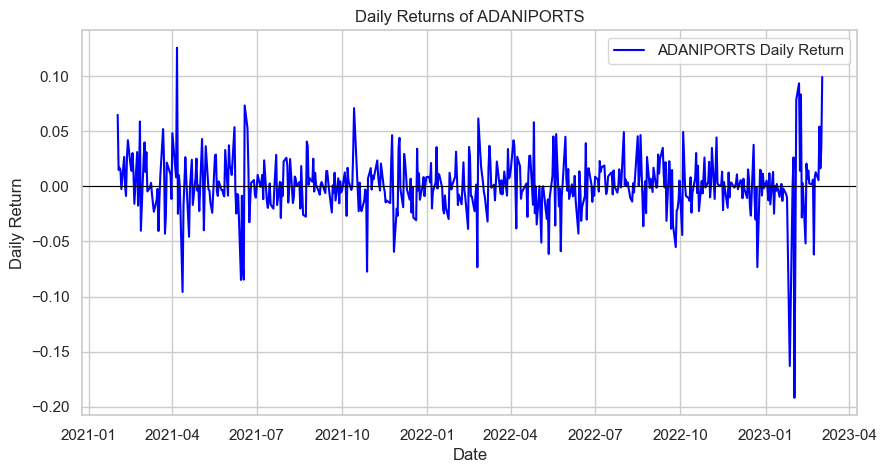

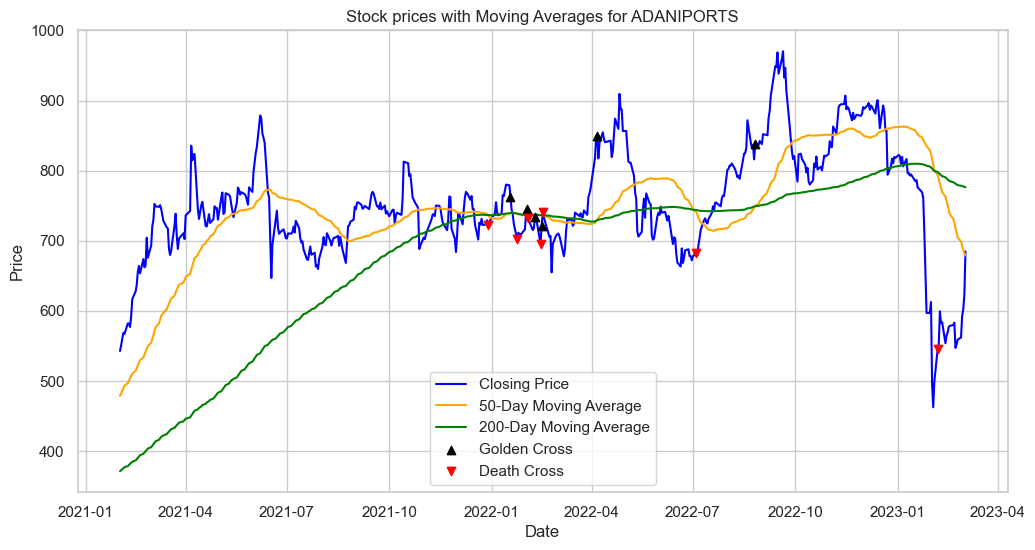

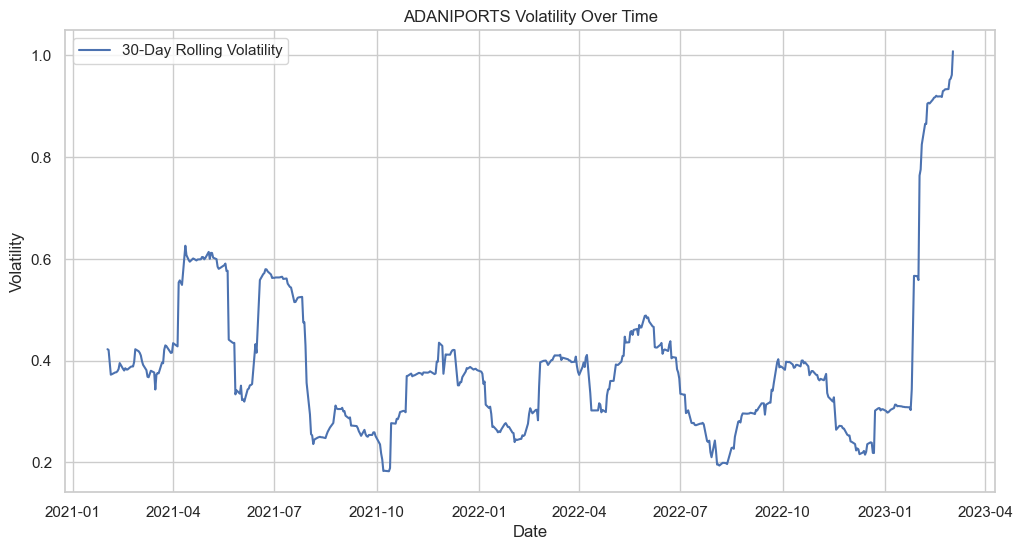

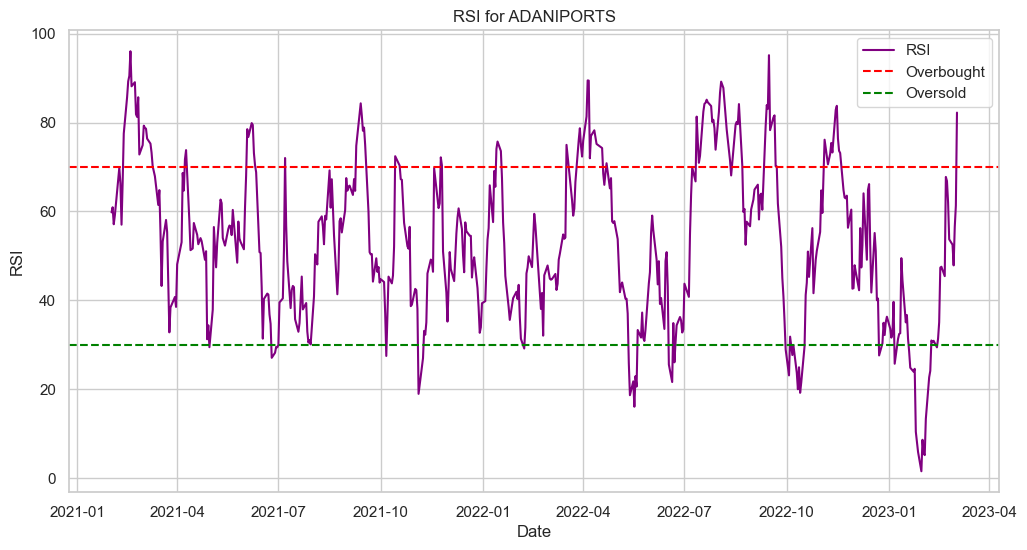

In [7]:

symbol='ADANIPORTS'
start_date = '2021-02-01'
end_date = '2023-03-03'

print(symbol)
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")


filtered_data=stock_data[symbol].loc[start_date:end_date]

# display the last few rows of the daily returns for given company
print(filtered_data.tail())

#display metrics
print(f"Average Daily Return of {symbol} : {metrics[symbol]['avg_return']:.4f}")
print(f"Annual Volatility (Standard Deviation) of {symbol} : {metrics[symbol]['volatility']:.4f}")

# visualize the daily returns
plt.figure(figsize=(10, 5))
plt.plot(filtered_data['daily_return'], label=f'{symbol} Daily Return',color='blue')
plt.title(f'Daily Returns of {symbol}')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linewidth=0.8)  # Line at y=0 for reference
plt.legend()
plt.show()


# Plot the closing price along with the moving averages
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['close'], label='Closing Price', color='blue')
plt.plot(filtered_data['50_MA'], label='50-Day Moving Average', color='orange')
plt.plot(filtered_data['200_MA'], label='200-Day Moving Average', color='green')

# Plot the cross points
plt.scatter(filtered_data.index[filtered_data['Golden_Cross']], filtered_data['close'][filtered_data['Golden_Cross']], label='Golden Cross', marker='^', color='black',zorder=3)
plt.scatter(filtered_data.index[filtered_data['Death_Cross']], filtered_data['close'][filtered_data['Death_Cross']], label='Death Cross', marker='v', color='red',zorder=3)

plt.title(f'Stock prices with Moving Averages for {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['volatility'], label='30-Day Rolling Volatility')
plt.title(f'{symbol} Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot the RSI
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title(f'RSI for {symbol}')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

### Portfolio Creation and Assesing Metrics

Generated 250 portfolios.
Portfolio # 1
      stocks   weights
0       ONGC  0.001109
1       SBIN  0.375447
2      CIPLA  0.061887
3     MARUTI  0.024635
4      TITAN  0.011099
5   ADANIENT  0.171443
6      WIPRO  0.111240
7        UPL  0.097674
8  TATASTEEL  0.091200
9   AXISBANK  0.054267
Annual return : 35.010701398296604 %
Volatility : 23.857731560053775 %
Sharpe ratio:  1.3417328180477044
Concentrated portfolio



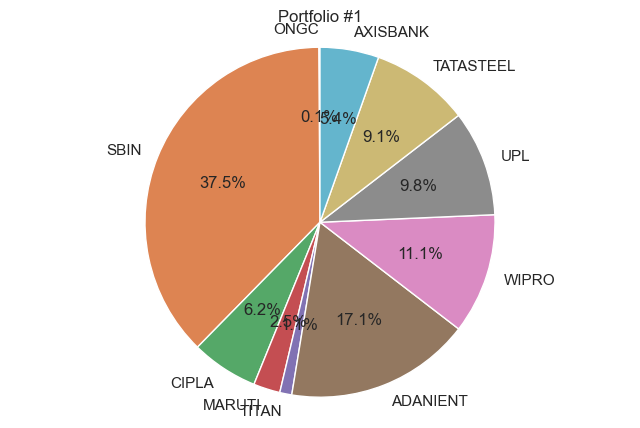

Portfolio # 2
       stocks   weights
0   NESTLEIND  0.048140
1         M&M  0.059721
2  ASIANPAINT  0.030895
3  HEROMOTOCO  0.073525
4  INDUSINDBK  0.087853
5       TITAN  0.091811
6        ONGC  0.174805
7   COALINDIA  0.276113
8    HDFCBANK  0.011587
9       WIPRO  0.145550
Annual return : 21.33705486028353 %
Volatility : 19.361921175006486 %
Sharpe ratio:  0.9470679430279928
Concentrated portfolio



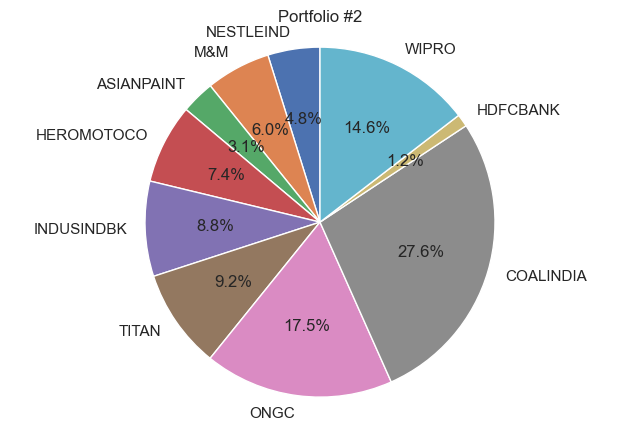

Portfolio # 3
        stocks   weights
0     AXISBANK  0.135862
1   BAJAJFINSV  0.021475
2   BAJAJ-AUTO  0.121272
3   HEROMOTOCO  0.119244
4         NTPC  0.036587
5    SUNPHARMA  0.100365
6   BAJFINANCE  0.036377
7   APOLLOHOSP  0.057751
8           LT  0.014718
9         BPCL  0.001708
10        ONGC  0.028390
11    RELIANCE  0.193637
12     SBILIFE  0.031316
13   POWERGRID  0.063295
14   KOTAKBANK  0.038003
Annual return : 14.714189253874228 %
Volatility : 16.213861190818527 %
Sharpe ratio:  0.7224799272678896
Diversified portfolio



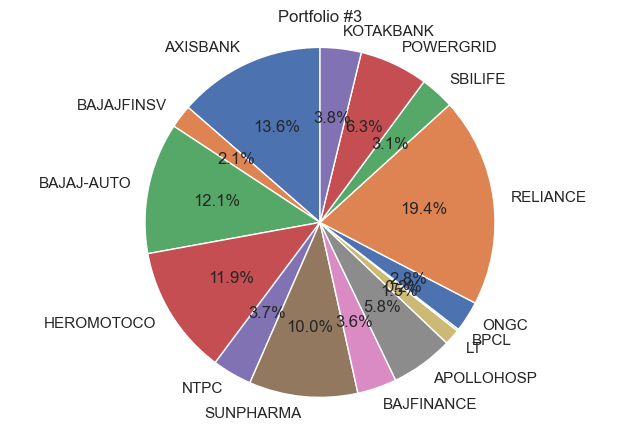

Portfolio # 4
        stocks   weights
0         ONGC  0.191276
1     HINDALCO  0.035942
2   ADANIPORTS  0.067059
3        CIPLA  0.009146
4        TITAN  0.008502
5          UPL  0.090313
6     RELIANCE  0.005641
7     ADANIENT  0.103361
8     JSWSTEEL  0.037509
9    TATASTEEL  0.106246
10        BPCL  0.086027
11      GRASIM  0.078604
12   SUNPHARMA  0.016398
13    AXISBANK  0.014162
14   COALINDIA  0.006042
15  BAJAJFINSV  0.038968
16  ASIANPAINT  0.019867
17         M&M  0.054024
18   KOTAKBANK  0.009791
19         TCS  0.021122
Annual return : 30.241663367954924 %
Volatility : 22.382733685282314 %
Sharpe ratio:  1.2170838357366323
Diversified portfolio



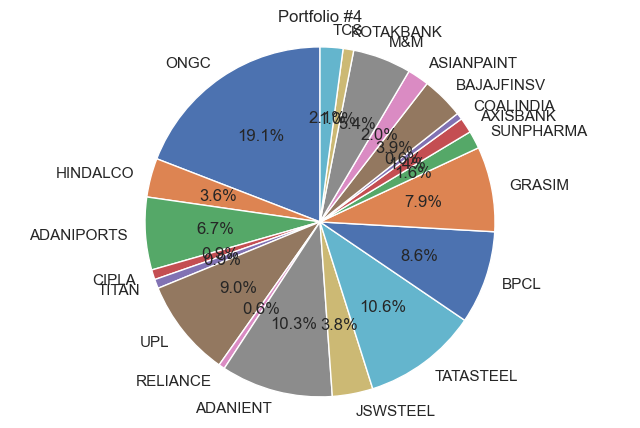

Portfolio # 5
       stocks   weights
0  HINDUNILVR  0.416137
1  ASIANPAINT  0.583863
Annual return : 9.31507657365427 %
Volatility : 20.877063525547328 %
Sharpe ratio:  0.30248873678649735
Concentrated portfolio



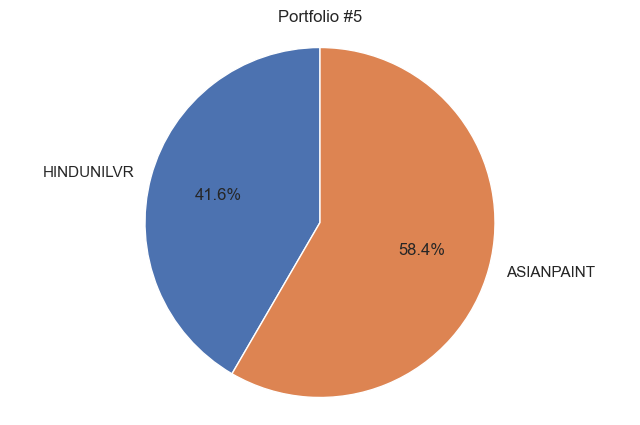

In [8]:
def generate_random_portfolios(nifty50_companies, num_portfolios=100, num_stocks=20):
    portfolios = []
    symbols = list(set(nifty50_companies['Symbol']))
    
    for _ in range(num_portfolios):
        n= random.randint(2, num_stocks)
        selected_stocks = random.sample(symbols, n)
        weights = np.random.dirichlet(np.ones(n), size=1)[0]  # random weights summing to 1
        portfolio = {
            'stocks': selected_stocks,
            'weights': weights
        }
        portfolios.append(pd.DataFrame(portfolio))
    
    return portfolios


def calculate_portfolio_metrics(portfolio, stock_data,start_date,end_date):
    selected_stocks = portfolio['stocks']
    weights = portfolio['weights']
    
    returns_df = pd.DataFrame()
    for stock in selected_stocks:
        returns_df[stock] = stock_data[stock]['daily_return'].loc[start_date:end_date]
    
    
    # calculate portfolio return and volatility
    mean_returns = returns_df.mean()
    cov_matrix = returns_df.cov()
    
    portfolio_return = np.dot(weights, mean_returns) * 252  # annualize return (252 trading days)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # annualize volatility
    
    # sharpe Ratio (assuming a risk-free rate of 3%)
    risk_free_rate = 0.03
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Classify portfolios into diversified and concentrated
def classify_portfolio(portfolio, nifty50_companies):
    selected_stocks = portfolio['stocks']
    weights = portfolio['weights']
    
    # Get the sectors of the selected stocks
    selected_sectors = nifty50_companies[nifty50_companies['Symbol'].isin(selected_stocks)]['Industry'].values
    num_sectors = len(set(selected_sectors))

    # Calculate concentration index (sum of squared weights)
    concentration_index = sum(w**2 for w in weights) #smaller value indicates higher diversification
    
    
    return (num_sectors>7 or len(selected_stocks)>5) and concentration_index < 0.15  
    

def plot_portfolio(stocks, weights, title):
    plt.figure(figsize=(8, 5))
    plt.pie(weights, labels=stocks, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')  # equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

   
start_date = '2021-02-01'
end_date = '2023-03-03'

# generate portfolios with random number of stocks and random weights
portfolios = generate_random_portfolios(nifty50_companies, num_portfolios=250, num_stocks=20)

print(f"Generated {len(portfolios)} portfolios.")


# calculate metrics for all generated portfolios
portfolio_metrics = []
for portfolio in portfolios:
    ret, vol, sharpe = calculate_portfolio_metrics(portfolio, stock_data,start_date,end_date)
    classification = classify_portfolio(portfolio, nifty50_companies)
    portfolio_metrics.append({'return': ret, 'volatility': vol, 'sharpe_ratio': sharpe,'diversified':classification})
portfolio_df=pd.DataFrame(portfolio_metrics)

#printing first 5 portfolios
for i in range(5):
    print("Portfolio #", i+1)
    print(portfolios[i])
    x=portfolio_metrics[i]
    print("Annual return :",x['return']*100,"%")
    print("Volatility :",x['volatility']*100, "%")
    print("Sharpe ratio: ",x['sharpe_ratio'])
    if(x['diversified']):
        print("Diversified portfolio\n")
    else:
        print("Concentrated portfolio\n")
    plot_portfolio(portfolios[i]['stocks'], portfolios[i]['weights'], 'Portfolio #'+str(i+1))
    




### Sharpe Ratio Visualisation

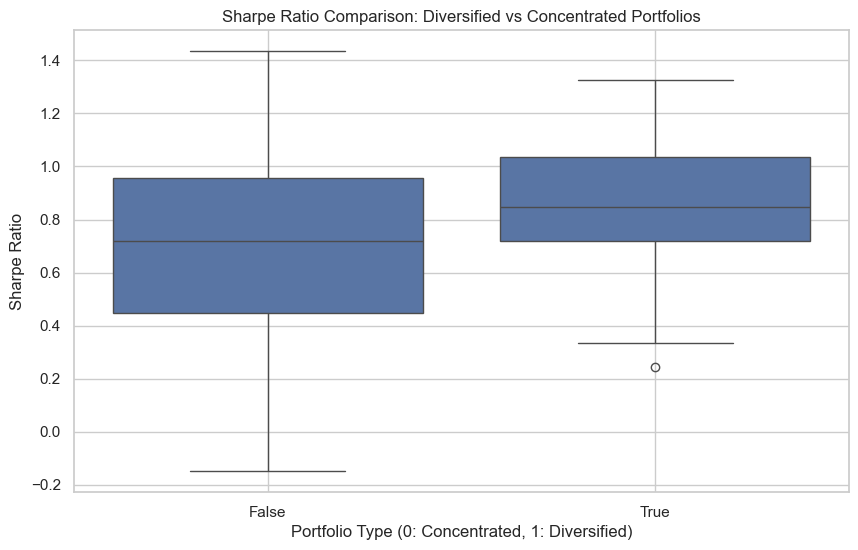

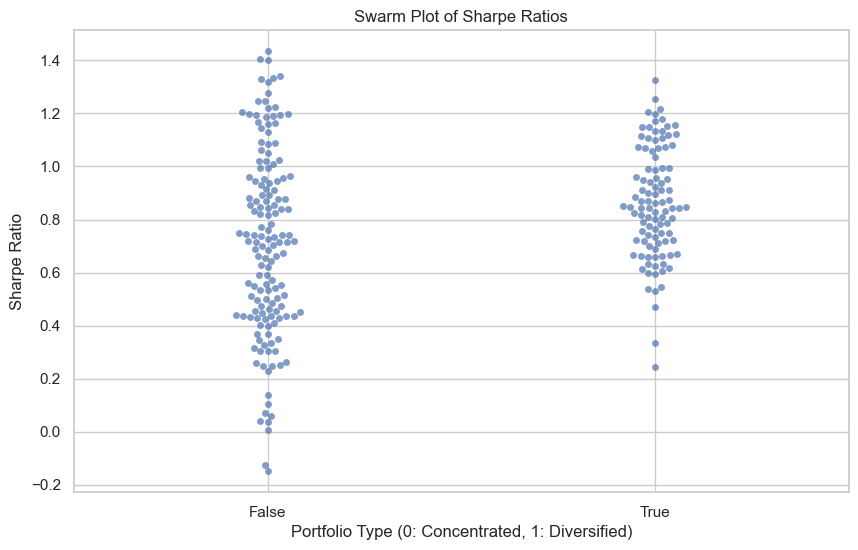

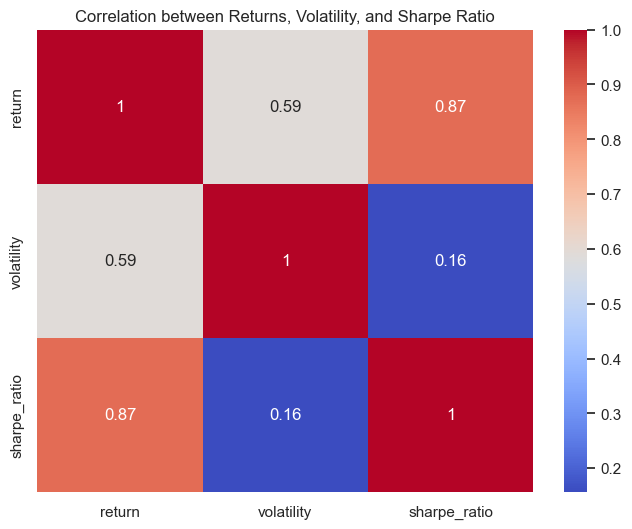

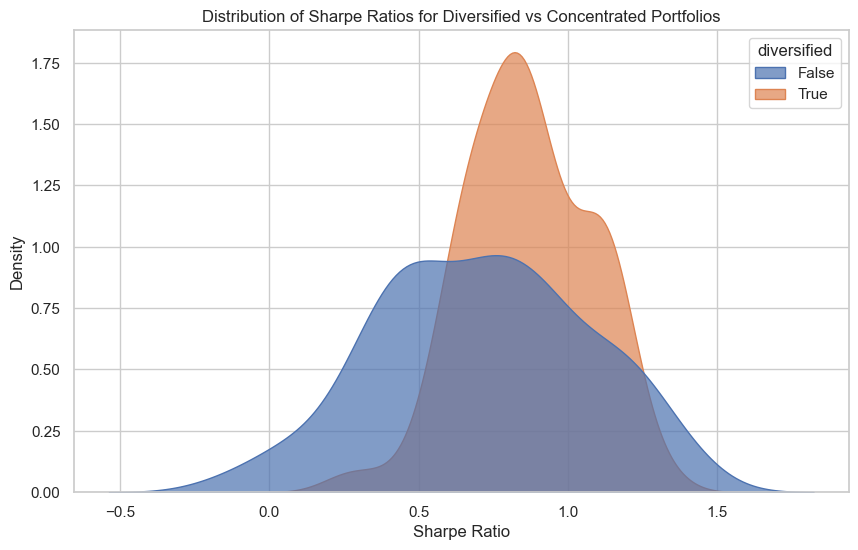

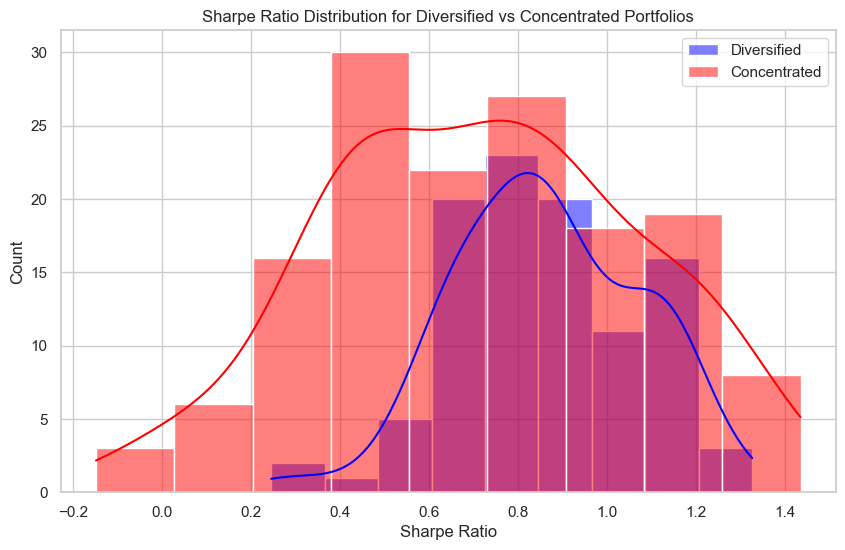

In [9]:
# Box plot of sharpe ratios
plt.figure(figsize=(10, 6))
sns.boxplot(x='diversified', y='sharpe_ratio', data=portfolio_df)
plt.xlabel('Portfolio Type (0: Concentrated, 1: Diversified)')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Comparison: Diversified vs Concentrated Portfolios')
plt.grid(True)
plt.show()


# Swarm plot to show individual data points
plt.figure(figsize=(10, 6))
sns.swarmplot(x='diversified', y='sharpe_ratio', data=portfolio_df, alpha=0.7)
plt.xlabel('Portfolio Type (0: Concentrated, 1: Diversified)')
plt.ylabel('Sharpe Ratio')
plt.title('Swarm Plot of Sharpe Ratios')
plt.grid(True)
plt.show()

# Correlation heatmap of metrics
correlation_matrix = portfolio_df[['return', 'volatility', 'sharpe_ratio']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Returns, Volatility, and Sharpe Ratio')
plt.show()

# Distribution plot of Sharpe Ratios using kdeplot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=portfolio_df, x='sharpe_ratio', hue='diversified', fill=True, common_norm=False,alpha=0.7)
plt.xlabel('Sharpe Ratio')
plt.title('Distribution of Sharpe Ratios for Diversified vs Concentrated Portfolios')
plt.grid(True)
plt.show()


# Separate diversified and concentrated portfolios
diversified= portfolio_df[portfolio_df['diversified'] == 1]['sharpe_ratio']
concentrated = portfolio_df[portfolio_df['diversified'] == 0]['sharpe_ratio']

# Plot histograms for both categories
plt.figure(figsize=(10, 6))
sns.histplot(diversified, color='blue', label='Diversified', kde=True)
sns.histplot(concentrated, color='red', label='Concentrated', kde=True)
plt.xlabel('Sharpe Ratio')
plt.title('Sharpe Ratio Distribution for Diversified vs Concentrated Portfolios')
plt.legend()
plt.grid(True)
plt.show()


### Hypothesis Testing using T-test

In [10]:

# Perform a t-test
t_stat, p_value = stats.ttest_ind(diversified, concentrated)
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in Sharpe ratios is statistically significant.")
else:
    print("No significant difference in Sharpe ratios.")


T-Statistic: 3.8376817994862207, P-Value: 0.00015766483443268404
The difference in Sharpe ratios is statistically significant.
